In this post we'll be analyzing the number of issues open on the [Julia language](http://julialang.org)'s [issue tracker](https://github.com/JuliaLang/julia/issues?q=sort%3Aupdated-desc). We'll be counting both issues (bug reports, ideas, plans) and "pull requests" (PRs, code that has been submitted for review before merging it into the langauge). What I'm mainly interested in how the number of "open" issues/PRs varies over time, and how that relates to the total number of issues/PRs.

For this job we'll need three Julia packages, all made by community members:

* [`GitHub.jl`](https://github.com/WestleyArgentum/GitHub.jl), to query the issue tracker. We could do this manually through the GitHub API, but this is much easier.
* [`JLD.jl`](https://github.com/JuliaLang/JLD.jl), which we'll use to cache the API results in a file.
* [`Gadfly.jl`](https://gadflyjl.org), a plotting package for Julia.
* If you are on Julia 0.3, you'll also need [`Dates.jl`](https://github.com/quinnj/Dates.jl), which provides string-to-date conversions and more. Its built into the standard library in Julia 0.4, but Julia 0.4 hasn't been released as of the time of writing.

All of these can be installed with the Julia package manager, e.g. `Pkg.add("GitHub"); Pkg.add("JLD")` and so on. If you haven't used Julia in a while, you might want to run `Pkg.update()` first so you get the freshest versions of these packages.

First step, load the packages

In [ ]:
using GitHub, JLD, Gadfly
using Dates  # Only needed on Julia 0.3.x

We use the `issues` function of the `GitHub.jl` package to download every open and closed issue or pull request (PR) for the `julia` repository - this takes a while, as it needs to download a fair bit of data. You'll want to get an "auth token", so that Github won't bounce our request as a spam attack of some sort. You can get this by signing up for a Github account, if you don't already have one, and going to your settings page.

In [ ]:
# Replace with your token
TOKEN = "yourauthtokenhere"
# Authenticate with GitHub, so they know we're legit
my_auth = authenticate(TOKEN)
# Pull all open issues...
open_issues = issues(my_auth,"JuliaLang","julia",state="open")
# ... and all closed issues (10x as many of these)
closed_issues = issues(my_auth,"JuliaLang","julia",state="closed")
# Combine them into one vector of issues
all_issues = vcat(open_issues,closed_issues)

We'll create a little type that just keeps the creation and close dates.
If an issue is open, it doesn't have a close date, so we'll just use a time far in the future (Jan 1, 2099!) for now. The `DateTime` function creates a `DateTime` object from a string (or from manually spelling out a date).

In [ ]:
# Define our reduced issue type
type SimpleIssue
    created_at::DateTime
    closed_at::DateTime
end
# Provide a constructor that takes in
# cr   creation date
# cl   close data - might be `nothing` = open
SimpleIssue(cr::String,cl) = SimpleIssue(
    DateTime(cr), 
    cl == nothing ? DateTime(2099,1,1) : DateTime(cl) )

We now use the `JLD.jl` package to serialize this data to a file in case we want to come back and analyze it later. `JLD.jl` can save pretty much any Julia thing, even types you define. Read the README for caveats!

In [6]:
save("all_issues.jld","all_issues",
    [SimpleIssue(i.created_at, i.closed_at) for i in all_issues])

We'll pretend we're revisiting this some time in the future. Loading data is just the reverse of saving it with JLD:

In [5]:
all_issues = load("all_issues.jld", "all_issues");

Now for some actual work. We collect a vector of every date "seen" - this is basically every day something happened on the issue tracker, which is probably almost every day since the announcement of Julia.

In [6]:
all_create_dts = [Date(i.created_at) for i in all_issues]
all_close_dts = [Date(i.closed_at) for i in all_issues]
all_dates = unique(sort(vcat(all_create_dts,all_close_dts)))
length(all_dates)

1457

Now for the actual counting. We'll use a not-particularly-efficient method, but quick enough for the data at hand. For each issue/PR, simply increment a count for each date that the issue/PR was open (the dates between its opening and closing). We'll also keep a count of total opened ever versus date, and for every date, the ages for all open issues at that date.

In [7]:
open_at_count  = Dict{Date,Int}()
total_at_count = Dict{Date,Int}()
days_open_at   = Dict{Date,Vector{Int}}()
for d in all_dates
    open_at_count[d]  = 0
    total_at_count[d] = 0
    days_open_at[d]   = Int[]
end
# For each issue/PR...
for iss in all_issues
    create_dt = iss.created_at
    close_dt  = iss.closed_at
    # For every date...
    for d in all_dates
        # If the issue was made before...
        if create_dt <= d
            # Then it existed on this date
            total_at_count[d] += 1
            # If it was closed after this...
            if d <= close_dt
                # Then it is open on this date
                open_at_count[d] += 1
                # Its been open this long
                push!(days_open_at[d], Int(d - Date(create_dt)))
            end
        end
    end
end

To finish, lets plot these quantities versus time using `Gadfly` - just simple line plots will do.

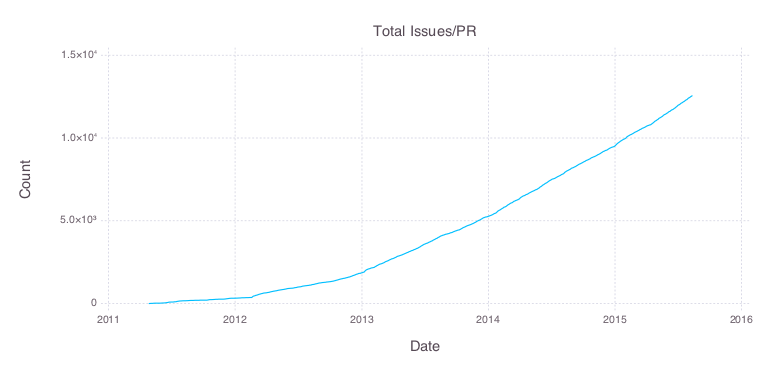

In [14]:
# Collect results into vectors
open_vec  = [open_at_count[d]  for d in all_dates]
total_vec = [total_at_count[d] for d in all_dates]
# Correct for special last day (currently open)
plot_dates = vcat(all_dates[1:end-1], all_dates[end-1]+Day(1))
# Draw the results as a PNG (default is SVG)
draw(PNG(8inch,4inch),
plot(x=plot_dates,y=total_vec,Geom.line,
        Guide.Title("Total Issues/PR"),
        Guide.xlabel("Date"), Guide.ylabel("Count"))
)

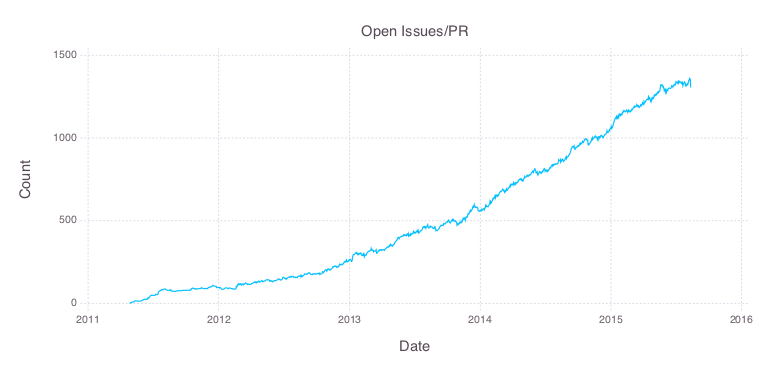

In [15]:
draw(PNG(8inch,4inch),
plot(x=plot_dates,y=open_vec,Geom.line,
        Guide.Title("Open Issues/PR"),
        Guide.xlabel("Date"), Guide.ylabel("Count"))
)

We'll now look at what fraction of the issues/PRs are open at any one time. As you can see, it seems to have "converged" to about 10% - I wonder why? One explanation is that whenever it gets much over 10% then people get the urge to review older issues and fix or close them. When it drops below 10%, people don't care too much. Another explanation is that there is a core of things in the "too hard" pile at any one time, and the number of those "too hard" things is going up but at no greater a rate than the overall number of issues.

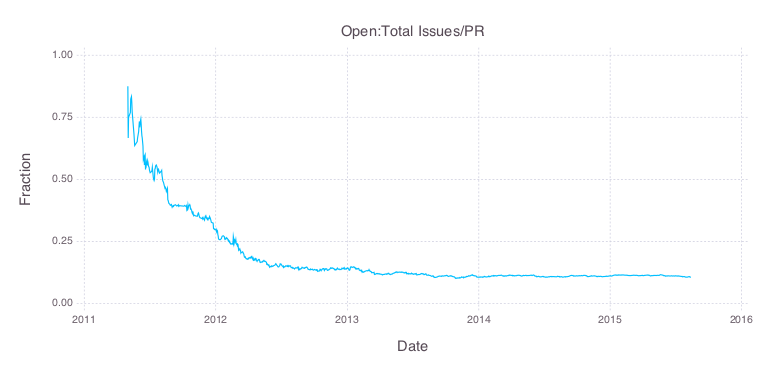

In [16]:
draw(PNG(8inch,4inch),
plot(x=plot_dates,y=open_vec./total_vec,Geom.line,
        Guide.Title("Open:Total Issues/PR"),
        Guide.xlabel("Date"), Guide.ylabel("Fraction"))
)

For a different perpsective, we can also analyze the distribution of the ages of the open issues/PRs. I'd would have guessed this was increasing, and sure enough it seems to be.

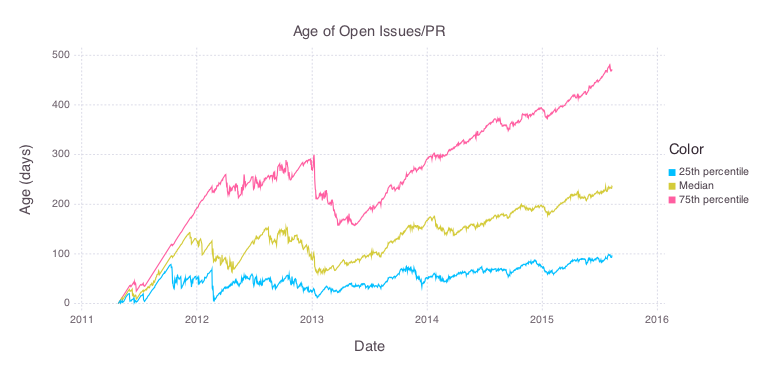

In [29]:
p25_age_vec = vcat(0.0,[quantile(days_open_at[d],0.25) for d in all_dates[2:end-1]])
p50_age_vec = vcat(0.0,[quantile(days_open_at[d],0.50) for d in all_dates[2:end-1]])
p75_age_vec = vcat(0.0,[quantile(days_open_at[d],0.75) for d in all_dates[2:end-1]])

draw(PNG(8inch,4inch), plot(
layer(  x=plot_dates[1:end-1],y=p25_age_vec,
        color=fill("25th percentile",length(p25_age_vec)),
        Geom.line),
layer(  x=plot_dates[1:end-1],y=p50_age_vec,
        color=fill("Median",length(p50_age_vec)),
        Geom.line),
layer(  x=plot_dates[1:end-1],y=p75_age_vec,
        color=fill("75th percentile",length(p75_age_vec)),
        Geom.line),
Guide.Title("Age of Open Issues/PR"),
Guide.xlabel("Date"), Guide.ylabel("Age (days)")))